In [1]:
import glob
import sys

sys.path.insert(0, "/home/ramain/packages/scintools/scintools/")
from scint_utils import write_results, get_true_anomaly, \
                        get_earth_velocity, read_results, \
                        float_array_from_dict, get_ssb_delay, \
                        read_par, pars_to_params
from scint_models import arc_curvature, effective_velocity_annual

import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
from astropy.time import Time

import corner
import lmfit
from lmfit import Minimizer


# Fitting arc curvatures or velocities

## Need to already have a scintools comptable parameters file and ephemeris

In [2]:
def plot_annual_orbital(params, mjd, y, yerr, vfit=1, pretty=1, N=500, anisotropy=1):
    """
    mjd: array of mjd values for your data points
    y:   y data which was fit.  eta when vfit=0, 1/sqrt(eta) when vfit=1
    yerr: y errors
    vfit: boolean, 0 if ydata are 1/sqrt(eta), 1 if y data are arc curvatures
    pretty: boolean, 1 to evaluate model smoothly, 
            0 to evaluate model only at data points
    """    
    
    Pyear = 365.25
    kmpkpc = 3.085677581e16
    d = params['d'].value * kmpkpc    
    if 's' in params.keys():
        s = params['s'].value
    else:
        d_s = params['d_s'].value
        s = 1. - d_s / results.params['d']

    if 'vism_psi' in params.keys():
        psi = params['psi']*np.pi/180
        vism_psi = params['vism_psi']
    else:
        vism_ra = results.params['vism_ra']
        vism_dec = results.params['vism_dec']
    
    Tref=Time('2013-01-01T00:00:00')
    Upoints = get_true_anomaly(mjd, pars)
    
    #mjd0 = mjd[0]
    #if mjd[-1] - mjd[0] < 365.25:
    #    mjd_plot = np.linspace(mjd[0], mjd[0]+365.25, N)
    #else:
    mjd_plot = np.linspace(mjd[0], mjd[-1], N)
    Uplot = get_true_anomaly(mjd_plot, pars)
    vearth_ra, vearth_dec = get_earth_velocity(mjd_plot, pars['RAJ'], pars['DECJ'])

    veff_ra, veff_dec, vp_ra, vp_dec  = effective_velocity_annual(
                                        params, Uplot,
                                        vearth_ra, vearth_dec)
    
    if anisotropy:   
        print("1D model")
        veff2_earthmodel = ( (veff_ra -(1-s)*vp_ra)*np.sin(psi) + 
                            (veff_dec-(1-s)*vp_dec)*np.cos(psi) - vism_psi )**2
        veff2_pmodel = ( (veff_ra -s*vearth_ra)*np.sin(psi) + 
                        (veff_dec- s*vearth_dec)*np.cos(psi) - vism_psi )**2
        veff2_full = ( veff_ra*np.sin(psi) + 
                        veff_dec*np.cos(psi) - vism_psi )**2
    else:
        print("isotropic model")
        veff2_earthmodel = ( (veff_ra - (1-s)*vp_ra - vism_ra)**2 + 
                             (veff_dec - (1-s)*vp_dec - vism_dec)**2 )
        veff2_pmodel = ( (veff_ra - s*vearth_ra - vism_ra)**2 + 
                        (veff_dec - s*vearth_dec - vism_dec)**2 )
        veff2_full = (veff_ra - vism_ra)**2 + (veff_dec - vism_dec)**2

    # Run on exact grid as data
    Upoints = get_true_anomaly(mjd, pars)
    vearth_ra, vearth_dec = get_earth_velocity(mjd, pars['RAJ'], pars['DECJ'])
    veff_ra, veff_dec, vp_ra, vp_dec = effective_velocity_annual(
                                        params, Upoints,
                                        vearth_ra, vearth_dec) 

    # Compute model v_eff with Earth's motion or Orbital motion subtracted
    if anisotropy:
        veff2 = (veff_ra*np.sin(psi) + veff_dec*np.cos(psi) - vism_psi)**2
        veff2_earth = ( (veff_ra -(1-s)*vp_ra)*np.sin(psi) + (veff_dec-(1-s)*vp_dec)*np.cos(psi) - vism_psi )**2
        veff2_p = ( (veff_ra -s*vearth_ra)*np.sin(psi) + (veff_dec- s*vearth_dec)*np.cos(psi) - vism_psi )**2
    else:
        veff2 = (veff_ra - vism_ra)**2 + (veff_dec - vism_dec)**2
        veff2_earth = ( (veff_ra - (1-s)*vp_ra - vism_ra)**2 + 
                             (veff_dec - (1-s)*vp_dec - vism_dec)**2 )
        veff2_p = ( (veff_ra - s*vearth_ra - vism_ra)**2 + 
                        (veff_dec - s*vearth_dec - vism_dec)**2 )
        
    modelorbit = d * s * (1 - s)/(2 * veff2_pmodel) * 1e-9
    modelannual = d * s * (1 - s)/(2 * veff2_earthmodel) * 1e-9
    modelfull = d * s * (1 - s)/(2 * veff2_full) * 1e-9

    if vfit:
        modelorbit = 1.e3 / np.sqrt(modelorbit)
        modelannual = 1.e3 / np.sqrt(modelannual)
        modelfull = 1.e3 / np.sqrt(modelfull)

    plt.figure(figsize=(8,8))

    ax1 = plt.subplot2grid((2, 2), (0, 0), colspan=2)
    ax2 = plt.subplot2grid((2, 2), (1, 0))
    ax3 = plt.subplot2grid((2, 2), (1, 1))
    plt.subplots_adjust(hspace=0.15)

    if anisotropy == 0:
        iso = 2
    else:
        iso = 1
    ax1.set_title('{0}, {1}D'.format(psrname, iso), fontsize=16)
    ax1.errorbar(mjd, y, yerr, fmt='.', markersize=10, color='k', alpha=0.5)
    if pretty:
        ax1.plot(mjd_plot, modelfull, color='r')
    else:
        ax1.plot(mjd, curvature_model, color='r')

    ax1.set_xlabel('MJD', fontsize=14)

    if vfit:
        mjdyear = (mjd-Tref.mjd)%Pyear
        
        vorb = y / np.sqrt(veff2/veff2_p)
        vorb_err = yerr / np.sqrt(veff2/veff2_p)

        vann = y / np.sqrt(veff2/veff2_earth)
        vann_err = yerr / np.sqrt(veff2/veff2_earth)

        vdata = y / np.sqrt(veff2/veff2_p)
        vdata_err = yerr / np.sqrt(veff2/veff2_p)

        ax2.errorbar(mjdyear, vann, vann_err, fmt='.', markersize=10, color='k', alpha=0.5)
        ax3.errorbar(Upoints, vorb, vorb_err, fmt='.', markersize=10, color='k', alpha=0.5)
        
        ax1.set_ylabel(r'$ 10^{3}\ \eta^{-1/2}\ $ ($\sqrt{\rm{m}} \rm{s}^{-1}$)', fontsize=14)
        ax2.set_ylabel(r'$ 10^{3}\ \eta^{-1/2}\ $ ($\sqrt{\rm{m}} \rm{s}^{-1}$)', fontsize=14)

        ymax = 1.4*max(y)

    else:
        #ax3.errorbar(mjd%PB / PB, eta*(veff2/veff2_p), etaerr*(veff2/veff2_p), fmt='.', color='k')
        ax3.errorbar(Uplot, eta*(veff2/veff2_p), etaerr*(veff2/veff2_p), fmt='.', color='k')
        ax1.set_ylabel(r'Arc curvature ($m^{-1}\, {mHz}^{-2}$)', fontsize=14)

        ax2.errorbar(mjd%Pyear, eta*(veff2/veff2_earth), etaerr*(veff2/veff2_earth), fmt='.', color='k')
        ymax = max(y)*2

    plt.subplots_adjust(wspace=0.05, hspace=0.2)    

    ax1.set_ylim(0, ymax)
    ax2.set_ylim(0, ymax)
    ax3.set_ylim(0, ymax)
    
    #ax3.set_xlim(-0.05,1.05)
    ax2.set_xlim(-18,365.25+18)
    
    ax3.axes.yaxis.set_ticklabels([])

    yearphase = (mjd_plot - Tref.mjd)%Pyear
    ax2.plot(yearphase, modelannual, 'r.', markersize=0.5)
    ax3.plot(Uplot, modelorbit, 'r.', markersize=0.3)
    
    ax3.set_xlabel('True Anomaly ', fontsize=14)
    ax2.set_xlabel('Day of Year', fontsize=14)
    
    return veff_ra, veff_dec


def log_likelihood(params, ydata, weights, true_anomaly, vearth_ra, vearch_dec, vfit):
    eta_model = arc_curvature(params, ydata, weights, true_anomaly, vearth_ra, vearch_dec,
                              vfit, modelonly=True)
    return -0.5 * np.sum((ydata-eta_model)**2 * weights**2)

def log_prior(params, priorvals):
    priorval = 0
    for p in priorvals:
        valname = p[0]
        val0 = p[1]
        valerr = p[2]
        par_i = params[valname]
        priorval = priorval + (par_i-val0)**2/valerr**2
    return -0.5 * priorval

def log_probability(params, ydata, weights, true_anomaly, vearth_ra, vearch_dec, vfit, priors=0):
    if 'priors' in locals():
        lp = log_prior(params, priors)
    else:
        lp = 0
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(params, ydata, weights, true_anomaly, vearth_ra, vearch_dec, vfit)

In [8]:
# read results of curvature fitting, and ephemeris for your pulsar
params = read_results('/home/ramain/Projects/ScintBinaries/J1643_screencomb_params.txt')
pars = read_par('/home/ramain/Projects/ScintBinaries/J1643-1224.par')

# vfit = 1 to fit 1 / sqrt(eta), proportional to v_eff
# vfit = 0 fits arc curvature directly (can diverge when V_eff - > 0!) 
# Anisotropy = 1 (1D screen) or = 0 (2D isotropic screen)
# Adjust_errors = 1 to scale by sqrt(redchi) before MCMC
# Adjust_errors = 0 to use errors as are
vfit = 1
anisotropy = False
adjust_errors = True

# Read data and convert to fload arrays
mjd = float_array_from_dict(params, 'mjd')
eta = float_array_from_dict(params, 'betaeta') 
etaerr = float_array_from_dict(params, 'betaetaerr') 

vefferr = 0.5*eta**(-1.5) * etaerr * 1e3
veff = 1 / np.sqrt(eta) * 1e3

sort_ind = np.argsort(mjd)
mjd = mjd[sort_ind]
eta = eta[sort_ind] 
etaerr = etaerr[sort_ind]
veff = veff[sort_ind]
vefferr = vefferr[sort_ind]

if vfit:
    y = np.copy(veff)
    yerr = np.copy(vefferr)
else:
    y = np.copy(eta)
    yerr = np.copy(etaerr)

"""
Do corrections to observation times
"""
print('Getting SSB delays')
tobs = float_array_from_dict(params, 'tobs')/86400  # tobs in days
ssb_delays = get_ssb_delay(mjd, pars['RAJ'], pars['DECJ'])
mjd += np.divide(ssb_delays, 86400)  # add ssb delay
mjd += tobs/2.


"""
Model the curvature
"""

print('Getting Earth velocity')
vearth_ra, vearth_dec = get_earth_velocity(mjd, pars['RAJ'], pars['DECJ'])

print('Getting true anomaly')
U = get_true_anomaly(mjd, pars)

nitr = 100  # number of random initial guesses
chisqr = np.Inf

# Create a params dictionary from pulsar par file
params = pars_to_params(pars)
pmra_0 = params['PMRA'].value
pmraerr_0 = params['PMRA_ERR'].value
pmdec_0 = params['PMDEC'].value
pmdecerr_0 = params['PMDEC_ERR'].value

try:
    D_0 = params['DIST'].value
    Derr_0 = params['DIST_ERR'].value
except:
    print("No distance in parfile, add manually")
    #D_0 = 1.0
    #Derr_0 = 0.2

print("Fitting...")
for itr in range(0, nitr):
    if itr%10 == 0:
        print("{0}/{1}".format(itr, nitr))
        
    # add parameters top fit
    params.add('d', value=D_0, vary=False)  # psr distance in kpc

    params.add('s', value=np.random.uniform(low=0, high=1),
               vary=True, min=0.0, max=1.0)  
    #params.add('d_s', value=np.random.uniform(low=0, high=D_0),
    #           vary=True, min=0.0, max=D_0)

    if anisotropy:
        params.add('vism_psi', value=np.random.normal(loc=0, scale=100),
                   vary=True, min=-1000, max=1000)
        params.add('psi', value=np.random.uniform(low=0, high=180),
                   vary=True, min=0, max=180)
    else:
        params.add('vism_ra', value=np.random.normal(loc=0, scale=20),
                   vary=True, min=-200, max=200)
        params.add('vism_dec', value=np.random.normal(loc=0, scale=20),
                   vary=True, min=-200, max=200)
    
    params.add('KIN', value=np.arccos(
                            np.random.uniform(low=-1, high=1))*180/np.pi,
               vary=True, min=0, max=180)
    params.add('KOM', value=np.random.uniform(low=0, high=360),
               vary=True, min=0, max=360)
    
    func = Minimizer(arc_curvature, params,
                     fcn_args=(y, 1/yerr, U,
                               vearth_ra, vearth_dec, vfit))

    results = func.minimize()
    if results.chisqr < chisqr:
        chisqr = results.chisqr
        results_new = results

pfit = results_new.params

pfit.add('PMRA', value=pmra_0, vary=True)
pfit.add('PMDEC', value=pmdec_0, vary=True)
pfit.add('d', value=D_0, vary=True, min=0., max=100.)

results = results_new
func = Minimizer(arc_curvature, pfit,
                 fcn_args=(y, 1/yerr, U,
                           vearth_ra, vearth_dec, 
                           vfit))

print("Reduced Chi Squared = {0}".format(results.redchi) )

if adjust_errors:
    yerr = yerr * np.sqrt(results.redchi)

Getting SSB delays
WARNING! Understand sign of SSB correction before applying to MJDs
Getting Earth velocity
Getting true anomaly
Fitting...
0/100
10/100
20/100
30/100
40/100
50/100
60/100
70/100
80/100
90/100
Reduced Chi Squared = 15.150315386979335


# Input prior values and standard errors

If letting everything freely vary, use include_prior = 0

Doing mcmc posterior sample
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 100000
    # data points      = 1
    # variables        = 8
    chi-square         = 1.2883e+16
    reduced chi-square = 1.2883e+16
    Akaike info crit   = 53.0947122
    Bayesian info crit = 37.0947122
[[Variables]]
    RAJ:        4.379188 (fixed)
    DECJ:      -0.2167053 (fixed)
    RAJ_ERR:    4.888409e-06 (fixed)
    DECJ_ERR:   0.0003466543 (fixed)
    F0:         216.3733 (fixed)
    F0_ERR:     6.415953e-13 (fixed)
    F1:        -8.642704e-16 (fixed)
    F1_ERR:     8.67863e-21 (fixed)
    PEPOCH:     55000 (fixed)
    POSEPOCH:   55000 (fixed)
    DMEPOCH:    55000 (fixed)
    DM:         62.40488 (fixed)
    DM_ERR:     0.006403653 (fixed)
    DM1:        0 (fixed)
    DM2:        0 (fixed)
    DIST:       0.85 (fixed)
    DIST_ERR:   0.35 (fixed)
    PMRA:       6.10468985 +/- 0.04009035 (0.66%) (init = 6.10406)
    PMRA_ERR:   0.03903023 (fixed)
    PMDEC:      4.38702

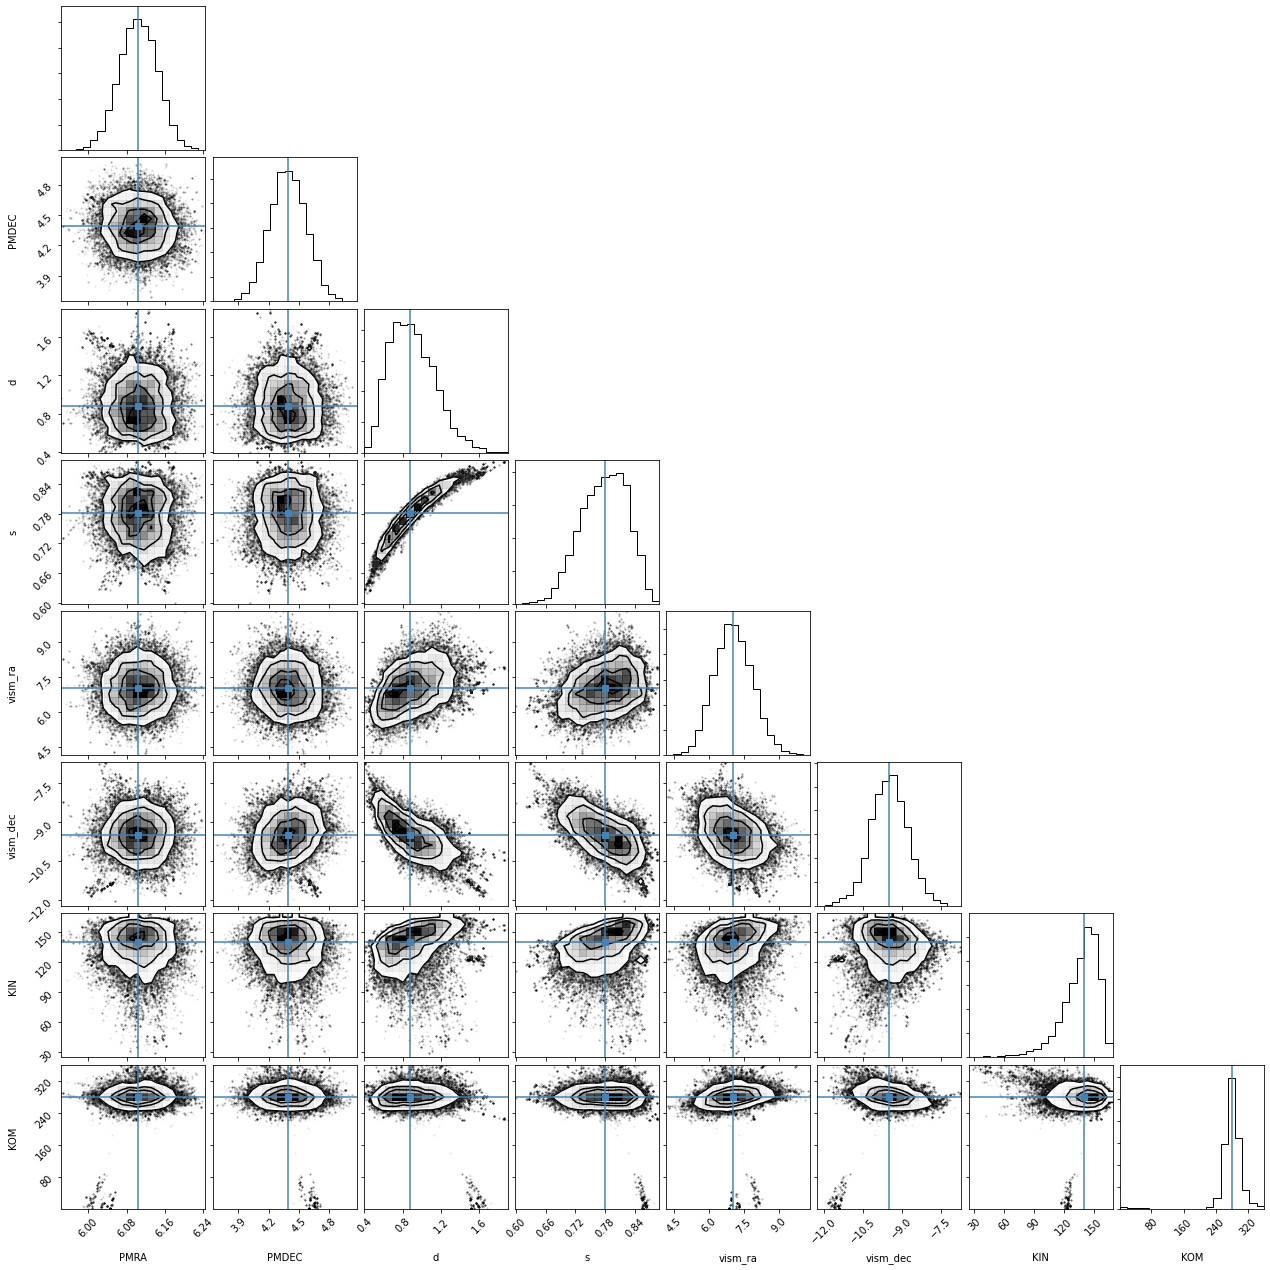

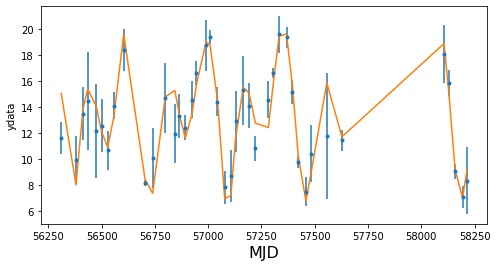

In [9]:
##### Input prior values and errors #####
include_prior = 1
priorpars = ['d', 'PMRA', 'PMDEC']
priorvals = [D_0, pmra_0, pmdec_0]
priorerrs = [Derr_0, pmraerr_0, pmdecerr_0]
priors = tuple( zip(priorpars, priorvals, priorerrs) )

if include_prior:
    func = Minimizer(log_probability, pfit,
                     fcn_args=(y, 1/yerr, U,
                               vearth_ra, vearth_dec, 
                               vfit, priors))
else:
    func = Minimizer(arc_curvature, pfit,
                     fcn_args=(y, 1/yerr, U,
                               vearth_ra, vearth_dec, 
                               vfit))

print('Doing mcmc posterior sample')    
mcmc_results = func.emcee(steps=1000, burn=300, nwalkers=100)
mcmc_unchanged = mcmc_results

truths = []
for var in mcmc_results.var_names:
    truths.append(mcmc_results.params[var].value)
labels = mcmc_results.var_names

corner.corner(mcmc_results.flatchain,
              labels=labels,
              truths=truths)
psrname = pars['PSRJ']
lmfit.report_fit(mcmc_results)
if anisotropy:
    alabel = '1D'
else:
    alabel = '2D'
plt.savefig('{0}_mcmc_{1}.pdf'.format(psrname, alabel))

"""
Now plot the fit
"""
curvature_model = arc_curvature(mcmc_results.params, y, yerr, U, vearth_ra, vearth_dec,
                                vfit, modelonly=True)                              

plt.figure(figsize=(8,4))
plt.errorbar(mjd, y, yerr, fmt='.')
plt.plot(mjd, curvature_model)
plt.xlabel('MJD', fontsize=16)
plt.ylabel('ydata')
plt.show()

# Plot the points and the model

isotropic model


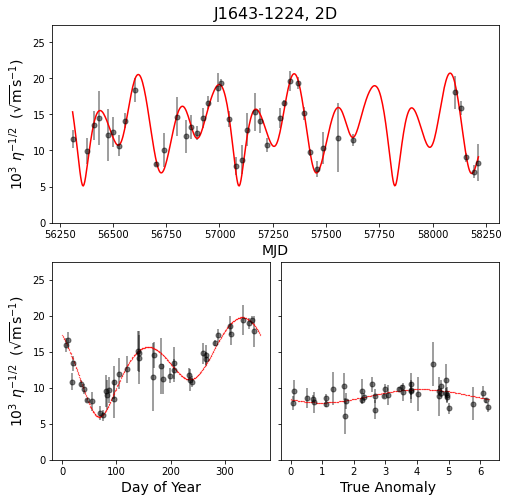

In [10]:
plot_annual_orbital(results.params, mjd, y, yerr, vfit, pretty=1, anisotropy=anisotropy)
plt.savefig('{0}_annualorbital_{1}.pdf'.format(psrname, alabel))